# Sentence Bi-directional Encoder Representations from Transformers (SBERT) finetuning.

Purpose of this notebook is to how how the SBERT model can be finetuned for a specific task. I will explore the Natural Language Inference (NLI) training approach of softmax loss to fine-tune models for producing sentence embeddings.

Be aware that softmax loss is no longer the preferred approach to training sentence transformers and has been superseded by other methods such as MSE margin and multiple negatives ranking loss. But we're covering this training method as an important milestone in the development of ever-improving sentence embeddings.

Model architecture:

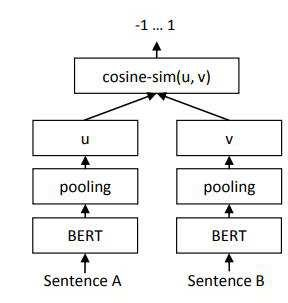


Here are some of the resources I used to create this notebook:

* James Briggs: Sentence Similarity with Sentence-Transformers in Python https://www.youtube.com/watch?v=Ey81KfQ3PQU&ab_channel=JamesBriggs
* James Briggs: Fine-tune Sentence Transformers the OG Way (with NLI Softmax loss) https://www.youtube.com/watch?v=aSx0jg9ZILo&t=1923s&ab_channel=JamesBriggs

Source Paper:
Reimers, Nils, and Iryna Gurevych. “Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks.” arXiv, August 27, 2019. http://arxiv.org/abs/1908.10084.


Beter method:
https://github.com/jamescalam/train-sentence-transformers/blob/94327317720a4a8cb70851969831e1885fe07f79/training/supervised/mnr/mnr-nli-negatives.ipynb#L43
https://github.com/jamescalam/train-sentence-transformers/blob/main/training/supervised/mnr/mnr-nli.ipynb

In [1]:
import os
import datasets
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from sentence_transformers import InputExample, SentenceTransformer, models, losses, util
from transformers.optimization import get_linear_schedule_with_warmup, AdamW

/home/saul/.pyenv/versions/3.11.5/envs/pytorch-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preparation

We are using the Stanford Natural Language Inference (SNLI) dataset, which has the following labels:

SNLI is a widely used benchmark in natural language processing (NLP) and machine learning research. It was created by the Stanford NLP Group to evaluate models on the task of natural language inference, which involves determining the logical relationship between pairs of sentences.

The SNLI dataset consists of over half a million labeled pairs of sentences, collected from image captions on the Flickr website. Each pair of sentences is labeled with one of three classes indicating the relationship between them: "entailment," "contradiction," or "neutral." These labels represent whether the meaning of the first sentence logically entails, contradicts, or is neutral with respect to the meaning of the second sentence.

    0: entailment, the premise entails the hypothesis e.g. the sentences have the same meaning
    1: neutral, the premise and hypothesis are neutral e.g. the sentences could be true but have no relation
    2: contradiction, the premise contradicts the hypothesis e.g. the sentences have opposite meaning

In [2]:
snli = datasets.load_dataset('snli', split='train')
snli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})

In [3]:
# huggingface datasets can be spliced like a dataframe by key, but also can be spliced by index like a list
# snli["premise"]
snli[0:3]

{'premise': ['A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.'],
 'hypothesis': ['A person is training his horse for a competition.',
  'A person is at a diner, ordering an omelette.',
  'A person is outdoors, on a horse.'],
 'label': [1, 2, 0]}

We also look at the MultiNL (MNLI) dataset.

MNLI is another creation from the Stanford NLP Group, designed to further advance research in natural language processing (NLP) and machine learning. MNLI stands for Multi-Genre Natural Language Inference, and it serves as an extension and enhancement of the Stanford Natural Language Inference (SNLI) dataset.

In [4]:
mnli = datasets.load_dataset('glue', 'mnli', split='train')
mnli = mnli.remove_columns(['idx'])
mnli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [5]:
# datsets need to be concatenated before they can be used. But need preprecessing first as they don't have the same columns
dataset = datasets.concatenate_datasets([snli, mnli]) # len = 942_854 samples

/home/saul/.pyenv/versions/3.11.5/envs/pytorch-dev/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


## Tokenize and encode sentences

In [6]:
train_samples = []

for i, row in tqdm(enumerate(dataset)):
    train_samples.append(
        InputExample(
            texts=[row['premise'], row['hypothesis']], 
            label=row['label']
            ))
    if i == 99:
        break

99it [00:00, 23892.98it/s]


In [7]:
batch_size = 16
dataloader_train = DataLoader(train_samples, batch_size=batch_size, shuffle=True)

## Build Model Setup

In [8]:
bert = models.Transformer('bert-base-uncased')
pooler = models.Pooling(
    bert.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    )

model = SentenceTransformer(modules=[bert, pooler])


## Train Model

In [9]:
criterion = losses.SoftmaxLoss(
    model=model,
    sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
    num_labels=3,
    )

In [11]:
epochs = 1
warmup_steps = int(0.1 * len(dataloader_train) * epochs)
optimizer = AdamW(model.parameters(), lr=2e-5)
model.fit(
    train_objectives=[(dataloader_train, criterion)],
    epochs=epochs,
    warmup_steps=warmup_steps,
    output_path='./sbert_finetuned',
    show_progress_bar=True,
    )

/home/saul/.pyenv/versions/3.11.5/envs/pytorch-dev/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


## Inference

In [22]:
def sim_matrix(embeddings):
    sim = np.zeros((len(embeddings), len(embeddings)))
    for i in range(len(embeddings)):
        sim[i:,i] = util.cos_sim(
            embeddings[i], embeddings[i:]
            ).cpu().numpy().flatten()
    return sim

In [19]:
sentences = [
    "the fifty mannequin heads floating in the pool kind of freaked them out.",
    "she swore she just saw her sushi move.",
    "he embraced his new life as an eggplant.",
    "my dentist tells me that chewing bricks is very bad for your teeth.",
    "the dental specialist recommended an immediate stop to flossing with construction material.",
    "i used to practice weaving with spaghetti three hours a day.",
    "the white water rafting trip was suddenly haltted by the unexpected waterfall.",
    "the person would knit using noodles for a few hours a day.",
    "it was always dangerous to drive with him since he insisted the safety cones were a slalom course.",
    "the woman think she saw her raw fish and rice change positions.",
]

embeddings = model.encode(sentences, convert_to_tensor=True)

In [23]:
sim = sim_matrix(embeddings)

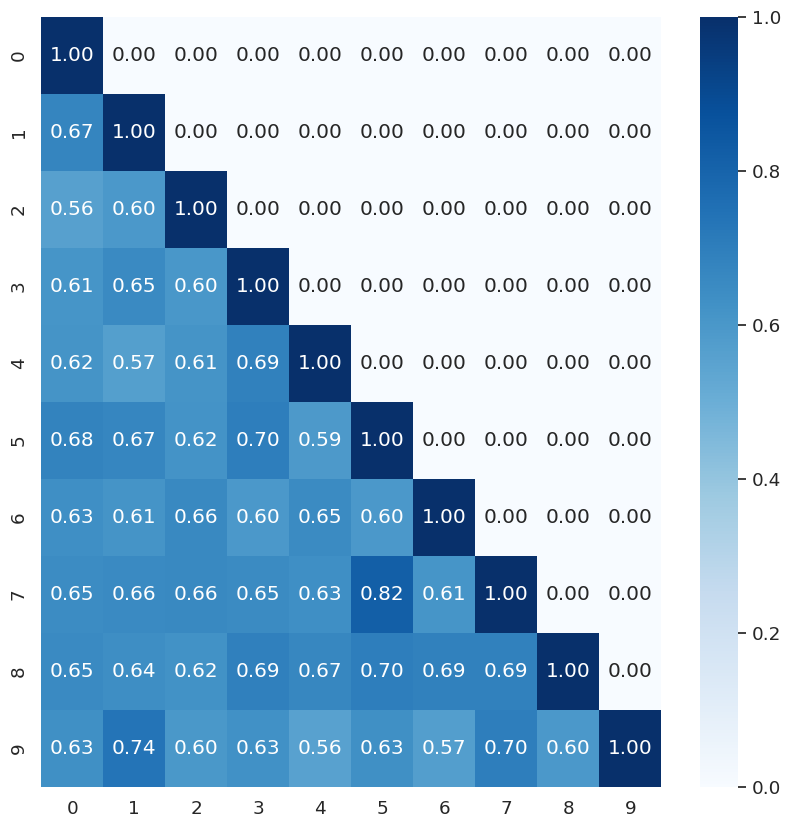

In [26]:
# plot the similarity matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(sim, annot=True, fmt='.2f', xticklabels=list(range(len(embeddings))), yticklabels=list(range(len(embeddings))), cmap='Blues')